In [1]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from estimation_fct import *
from graph_format import *

# Load model
from model import ModelClass

model = ModelClass() 

par = model.par
sol = model.sol
sim = model.sim


c:\Users\Peter\Design_retirement\model.py:128: RuntimeWarning: divide by zero encountered in double_scalars
  (par.r_s * (1 + par.r_s)**par.EL[int(r)]) / ((1 + par.r_s)**par.EL[int(r)] - 1)


In [2]:
# Prepare data
_, _, moments = prepare_data(par)

In [3]:
means_string = "Data ny def/mean_matrix.csv"
covariance_string = "Data ny def/variance_matrix.csv"

In [4]:
variables = ["yearly_hours", "formue_plsats", "extensive_v2"]

In [5]:
mean, variance_diag = load_and_process_data(means_string, covariance_string, par, variables)

In [6]:
variance_cut = np.concatenate([
    variance_diag[:45],
    variance_diag[55:55+70],
    variance_diag[55+70:55+70+45]
])

In [7]:
diag_inv = 1 / variance_cut
weight = np.diag(diag_inv)

In [8]:
def randomize_theta_init(theta_init, bounds, pct=0.05):
    randomized = []
    for val, (lower, upper) in zip(theta_init, bounds):
        delta = pct * val
        min_val = max(lower, val - delta)
        max_val = min(upper, val + delta)
        randomized_val = np.random.uniform(min_val, max_val)
        randomized.append(randomized_val)
    return np.array(randomized)

# Prepare SMM
theta_names = ("beta", "sigma", "gamma", "mu", "zeta", "beta_1", "gamma_1")

theta_init = np.array([0.9654276064, 1.1439276735, 1.9252802098, 6.2333816952, 8.3062287571, 0.0500726898, 0.0000108413])

# Original bounds
orig_bounds = [(0.0, 1.0),   # beta
               (0.1, 6.0),   # sigma
               (0.1, 10.0),  # gamma
               (0.0, 20.0),  # mu
               (0.0, 15.0),  # zeta
               (0.0, 1.0),
               (0.0, 0.0001)
               ] 

theta_init_scaled = scale_params(theta_init, orig_bounds)

theta_random = randomize_theta_init(theta_init, orig_bounds)
theta_random_scaled = scale_params(theta_random, orig_bounds)

In [ ]:
# Do SMM
objective = lambda theta: obj_func(theta, theta_names, mean, weight, model, orig_bounds, do_print=True)

res = minimize(
    objective, 
    theta_init_scaled,
    method='nelder-mead',
    bounds=[(0,1)] * len(theta_init_scaled),
    tol=1e-6,
    options={"maxiter":2000}
)

theta_final = unscale_params(res.x, orig_bounds)

print(theta_final)

0.9654276064, 1.1439276735, 1.9252802098, 6.2333816952, 8.3062287571, 0.0500726898, 0.0000108413, 
Error = 5.38261, Time = 206.3 seconds
0.9863010133, 1.1439276735, 1.9252802098, 6.2333816952, 8.3062287571, 0.0500726898, 0.0000108413, 
Error = 24.07420, Time = 74.9 seconds
0.9654276064, 1.1961240572, 1.9252802098, 6.2333816952, 8.3062287571, 0.0500726898, 0.0000108413, 
Error = 56.57693, Time = 75.2 seconds
0.9654276064, 1.1439276735, 2.0165442203, 6.2333816952, 8.3062287571, 0.0500726898, 0.0000108413, 
Error = 5.00674, Time = 76.0 seconds
0.9654276064, 1.1439276735, 1.9252802098, 6.5450507800, 8.3062287571, 0.0500726898, 0.0000108413, 
Error = 5.37002, Time = 75.0 seconds
0.9654276064, 1.1439276735, 1.9252802098, 6.2333816952, 8.7215401950, 0.0500726898, 0.0000108413, 
Error = 6.10935, Time = 75.3 seconds
0.9654276064, 1.1439276735, 1.9252802098, 6.2333816952, 8.3062287571, 0.0525763243, 0.0000108413, 
Error = 5.09056, Time = 75.7 seconds
0.9654276064, 1.1439276735, 1.9252802098, 6.2

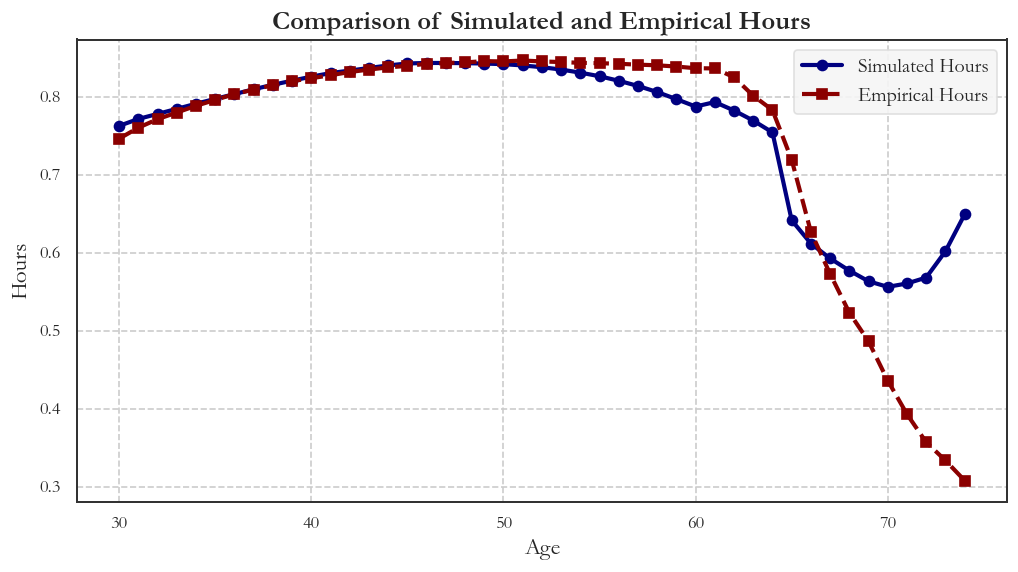

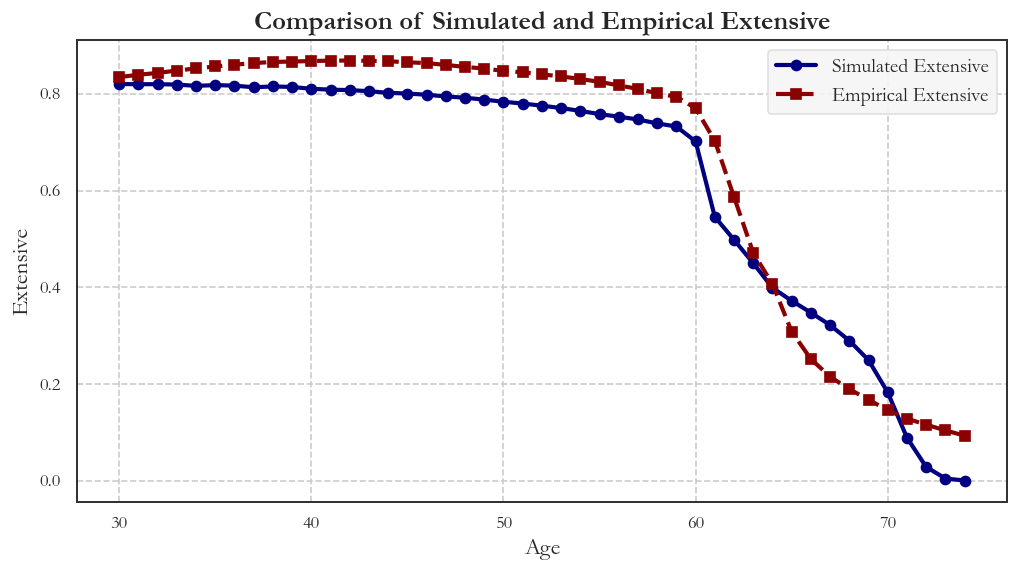

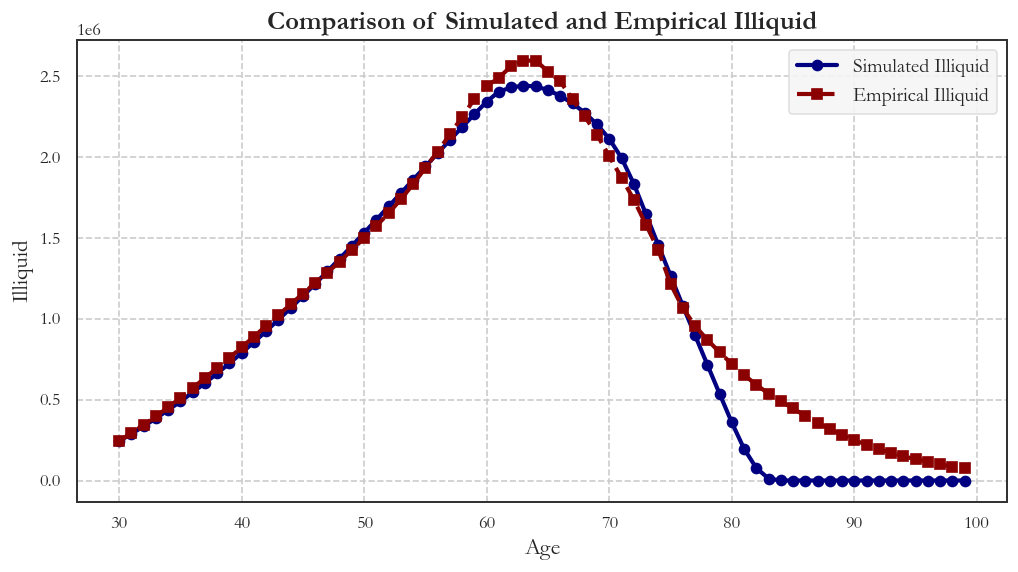

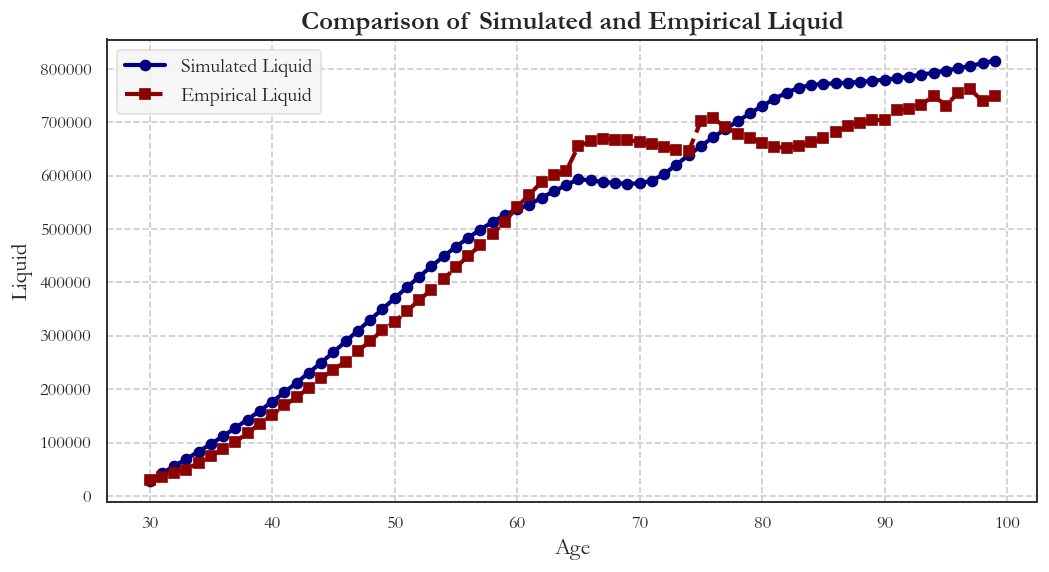

In [ ]:
# Load the model with calibrated values
theta_names = ("beta", "sigma", "gamma", "mu", "zeta", "beta_1", "gamma_1")
# theta_names = ("beta", "zeta")

# # theta_final = theta_init

# theta_final = np.array([0.9654276064, 1.1439276735, 1.9252802098, 6.2333816952, 8.3062287571, 0.0500726898, 0.0000108413])

for i, name in enumerate(theta_names):
    setattr(model.par, name, theta_final[i])

model.solve()
model.simulate()

# plot the graph with calibrated values 
a_dict = {
    'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan),axis=0)[:45], moments['hours']],
    'extensive': [np.mean(model.sim.ex, axis=0)[:45], moments['extensive']],
    'illiquid': [np.clip(np.mean(model.sim.s, axis=0), 0, None), moments['savings']],
    'liquid': [np.mean(model.sim.a, axis=0), moments['assets']]
}

# Define colors
simulated_color = "navy"  # Dark blue
empirical_color = "darkred"  # Dark red
ci_color = "lightcoral"  # Light red for confidence bands

for key, (simulated, empirical) in a_dict.items():
    plt.figure(figsize=(10, 5))
    
    x_vals = np.arange(len(empirical)) + par.start_age
    
    plt.plot(x_vals, simulated, label=f"Simulated {key.capitalize()}", marker="o", color=simulated_color)
    plt.plot(x_vals, empirical, label=f"Empirical {key.capitalize()}", linestyle="--", marker="s", color=empirical_color)

    # # 99.9% confidence interval
    # ci = std_dev
    # plt.fill_between(x_vals, empirical - ci, empirical + ci, color=ci_color, alpha=0.4, label="Empirical Standard Deviation")

    plt.xlabel("Age")
    plt.ylabel(key.capitalize())
    plt.title(f"Comparison of Simulated and Empirical {key.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# prepare your data dict
a_dict = {
    'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan), axis=0)[:55],
              moments['hours']],
    'extensive': [np.mean(model.sim.ex, axis=0)[:55],
                  moments['extensive']],
    'liquid': [np.mean(model.sim.a, axis=0),
               moments['assets']]
}


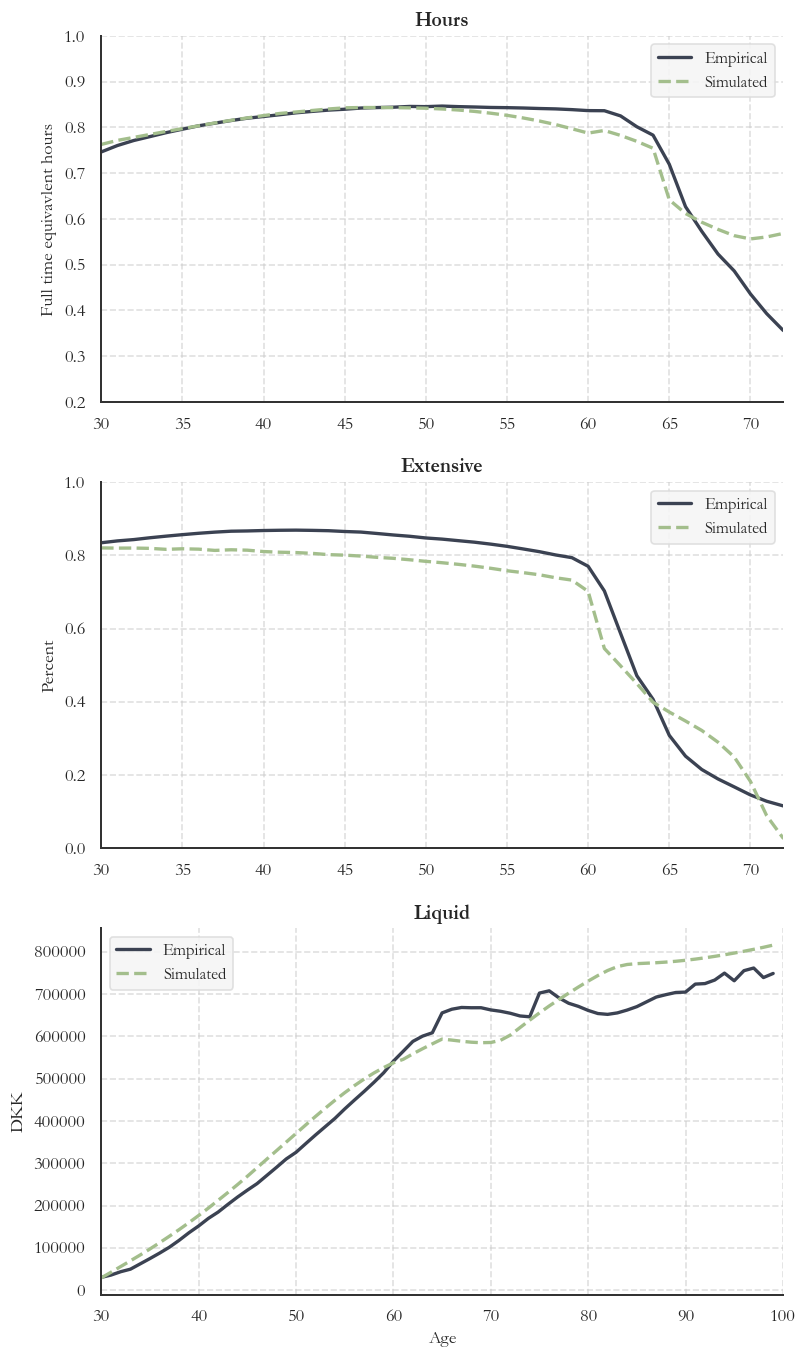

In [ ]:
plot_model_vs_data_grid(a_dict, title="", save_title="in_sample_fit.png")


In [ ]:
means_data = pd.read_csv("Data/mean_matrix.csv")

b_dict = {
    'illiquid': [np.clip(np.clip(np.mean(model.sim.s, axis=0), 0, None) / 1_000_000, 0, None),
                 moments['savings'] / 1_000_000]  ,
    'wages':    [np.nanmean(np.where(model.sim.ex==1, model.sim.w, np.nan)[:, :31] , axis=0),
                 means_data[means_data["alder"] <= 60]["hourly_salary_plsats_Mean"].to_numpy() * 1924]
        }

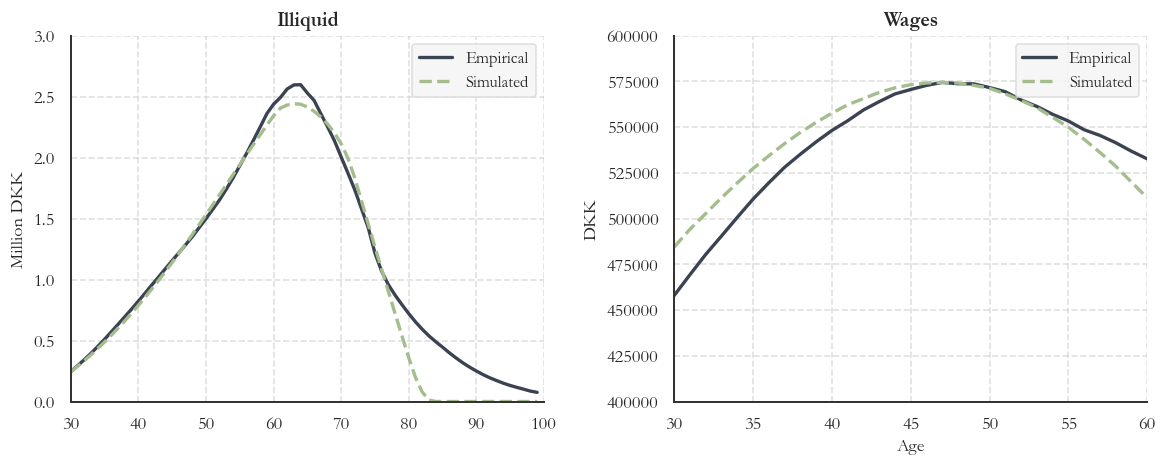

In [ ]:
plot_model_vs_data_grid_oos(b_dict, title="", save_title="out_of_sample_fit.png")
